In [1]:
import pandas                   
import pyspark
import pyspark.sql
from pyspark.sql                import SparkSession, DataFrame
#from pyspark.sql.Dataframe      import toDF
import pyspark.sql.types        as T
import pyspark.sql.functions    as F
import lib.pyspark_helper       as helper
import lib.visualizer           as visualizer
import lib.statistics           as stats
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings 

In [2]:
# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
spark = SparkSession.builder.master('local[*]').appName('risk').getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [4]:
df_repairs = spark.read.csv('./out/repairs.csv',header=True)
df_repairs = df_repairs.select(F.col('part'),F.col('serial_number'),F.col('item_type'),F.col('client'),F.col('date')).where(F.col('date').isNotNull())
df_repairs = df_repairs.withColumn('date',F.col('date').cast(T.DateType())) 
df_repairs = df_repairs.sort(F.col('date'),ascending=True)
df_repairs.show(5,truncate=False)
visualizer.visualise_dataframe(df_repairs)

+-------------+---------------+--------------------------+------+----------+
|part         |serial_number  |item_type                 |client|date      |
+-------------+---------------+--------------------------+------+----------+
|window plate |15036WL81035583|Ingenico iWL 221 GC [SBSA]|SBSA  |2020-01-10|
|charging port|15314WL81606321|Ingenico iWL 221 GC [SBSA]|SBSA  |2020-01-10|
|charging port|15211WL81371335|Ingenico iWL 221 GC [SBSA]|SBSA  |2020-01-10|
|printer      |15211WL81371335|Ingenico iWL 221 GC [SBSA]|SBSA  |2020-01-10|
|charging port|14266WL22179184|Ingenico iWL 221 GC [SBSA]|SBSA  |2020-01-10|
+-------------+---------------+--------------------------+------+----------+
only showing top 5 rows

root
 |-- part: string (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- client: string (nullable = true)
 |-- date: date (nullable = true)

Number of records: 117708
-RECORD 0-----------------------------------
 part      

## Visualise the Data

In [5]:
df_date         = df_repairs.groupBy('date').count().withColumnRenamed('count','repairs').sort('date',ascending=True)
df_date         = df_date.toPandas()
df_date         = df_date.dropna()
df_date['date'] = pandas.to_datetime(df_date['date'],format='%Y-%m-%d')
df_date         = df_date.set_index('date')
df_date         = df_date.fillna(0) 
df_date.sort_index(inplace=True)
print(df_date.dtypes) 

repairs    int64
dtype: object


In [6]:
y = df_date['repairs']
print(y)

date
2020-01-10     22
2020-02-06     24
2020-02-23     22
2020-03-31     42
2020-04-01    102
             ... 
2021-07-01    370
2021-07-02    430
2021-07-05    338
2021-07-06    382
2021-07-07    101
Name: repairs, Length: 385, dtype: int64


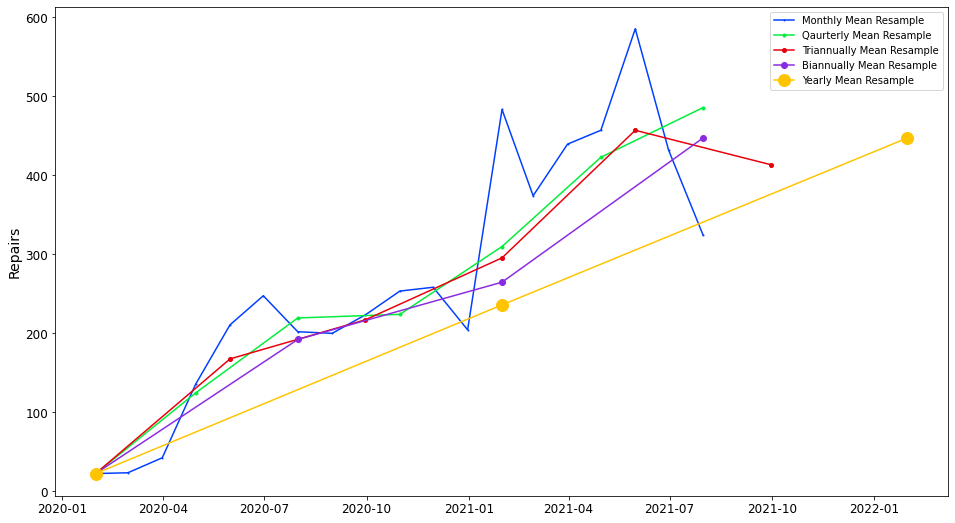

In [7]:
stats.plot_rolling_means(y)

## Decompose the Data

- Additive Model: y(t) = Level + Trend + Seasonality + Noise 
- Multiplicative Model: y(t) = Level * Trend * Seasonality * Noise

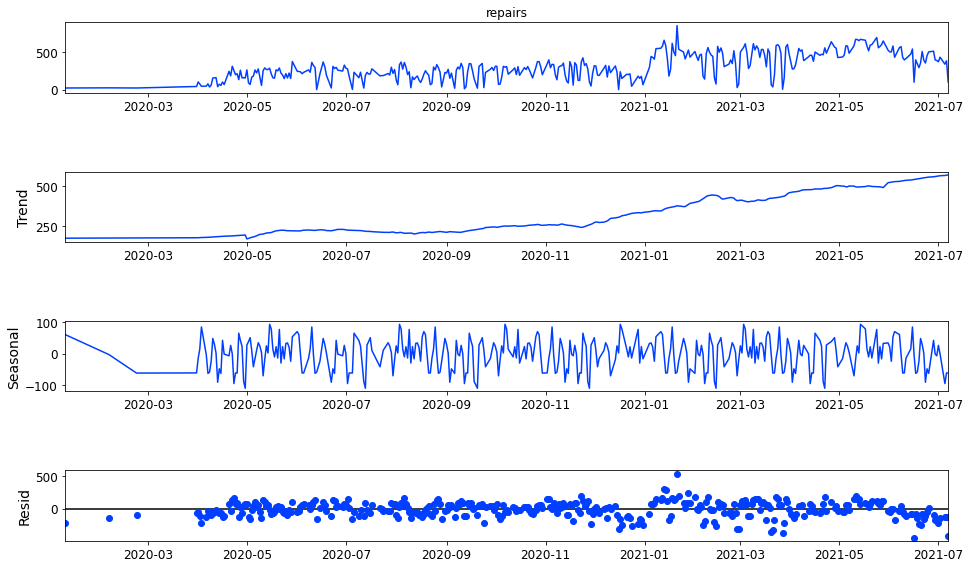

In [8]:
stats.seasonal_decompose(y,period=1,sm_model='additive',fig_size=(16,9))

#### Observations
##### 1.) Overall increasing trend
##### 2.) 6 month seasonality

## Testing for Stationarity

 > Is the raw data stationary ?
Test statistic = -2.565
P-value = 0.100
Critical values :
	1%: -3.447909006729481 - The data is not stationary with 99% confidence
	5%: -2.8692783343881483 - The data is not stationary with 95% confidence
	10%: -2.5708923751111112 - The data is not stationary with 90% confidence


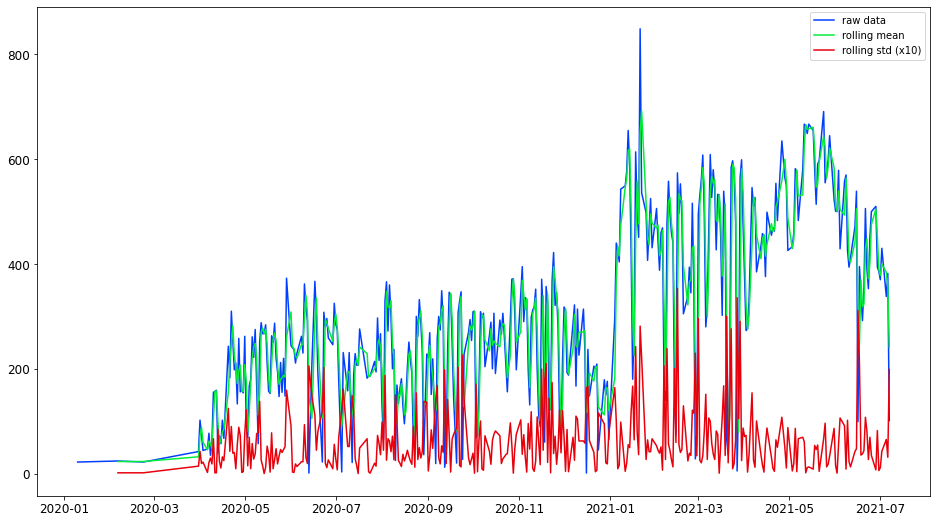

In [9]:
stats.ADF_test(y,title='raw data')
stats.test_stationarity(y,title='raw data',rolling_window=2)

## Making Data Stationary

### Detrending

 > Is the de-trended data stationary ?
Test statistic = -6.513
P-value = 0.000
Critical values :
	1%: -3.4483935212959844 - The data is  stationary with 99% confidence
	5%: -2.8694912343676497 - The data is  stationary with 95% confidence
	10%: -2.571005879151811 - The data is  stationary with 90% confidence


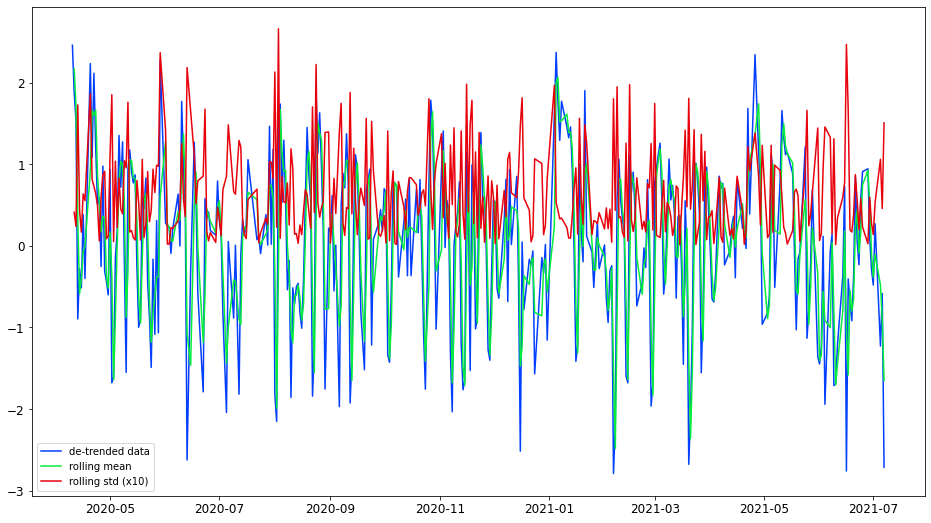

In [10]:
"""
This method removes the underlying trend in the time series: 
The results show that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again.
"""
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()
stats.ADF_test(y_detrend,'de-trended data')
stats.test_stationarity(y_detrend,'de-trended data',rolling_window=2)

### Differencing

 > Is the 7 lag differenced data stationary ?
Test statistic = -4.722
P-value = 0.000
Critical values :
	1%: -3.448645946352023 - The data is  stationary with 99% confidence
	5%: -2.869602139060357 - The data is  stationary with 95% confidence
	10%: -2.5710650077160495 - The data is  stationary with 90% confidence


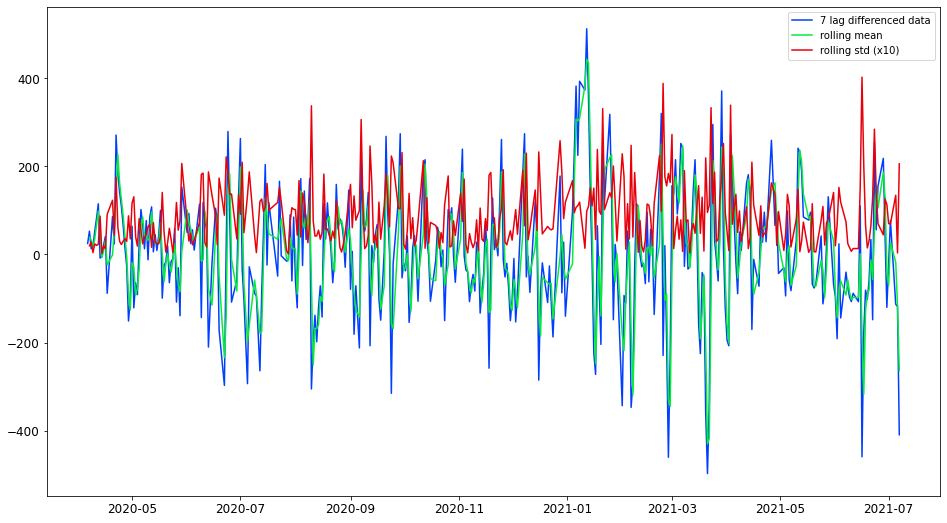

In [11]:
# Differencing
""" 
This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 7-month seasonality, I used a 7-lag difference:
"""
y_7lag =  y - y.shift(7)

stats.ADF_test(y_7lag,'7 lag differenced data')
stats.test_stationarity(y_7lag,'7 lag differenced data',rolling_window=2)

### Differencing + Detrending

 > Is the 7 lag differenced de-trended data stationary ?
Test statistic = -7.559
P-value = 0.000
Critical values :
	1%: -3.44911857009962 - The data is  stationary with 99% confidence
	5%: -2.8698097654570507 - The data is  stationary with 95% confidence
	10%: -2.5711757061225153 - The data is  stationary with 90% confidence


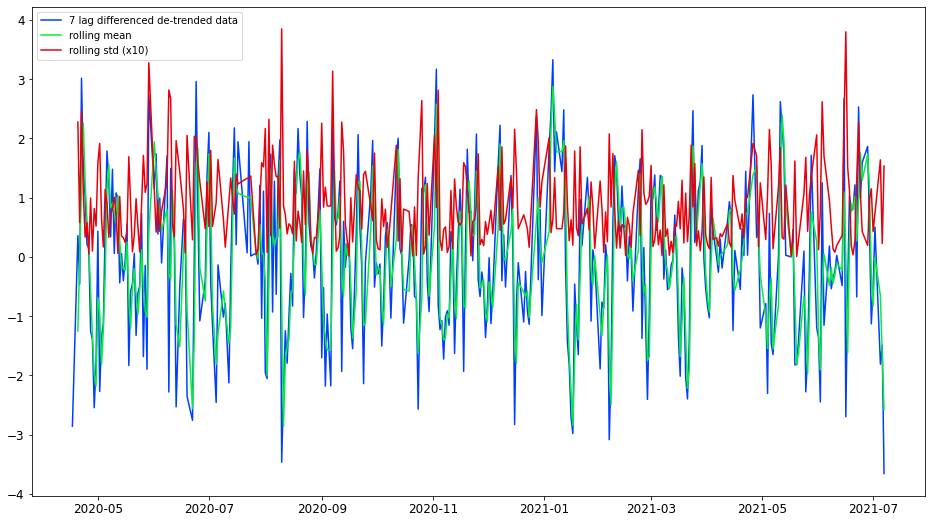

In [12]:
# Detrending + Differencing
"""

"""
y_7lag_detrend =  y_detrend - y_detrend.shift(7)

stats.ADF_test(y_7lag_detrend,'7 lag differenced de-trended data')
stats.test_stationarity(y_7lag_detrend,'7 lag differenced de-trended data',rolling_window=2)

## Creating Training and Testing Datasets

In [13]:
y_to_train      = y[:'2021-03-01']                                              # dataset to train
y_to_val        = y['2021-03-02':]                                              # last X months for test  
predict_date    = len(y - len(y[:'2021-03-02']))                                # the number of data points for the test set  

## Time Series Prediction Model

### Simmple Exponential Smooth (SES)

- Suitable for time series data without trend or seasonal components
- This model calculates the forecasting data using weighted averages. One important parameter this model uses is the smoothing parameter: α, and you can pick a value between 0 and 1 to determine the smoothing level. When α = 0, the forecasts are equal to the average of the historical data. When α = 1, the forecasts will be equal to the value of the last observation.

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 228.99
The Root Mean Squared Error of our forecasts with auto optimization is 233.81


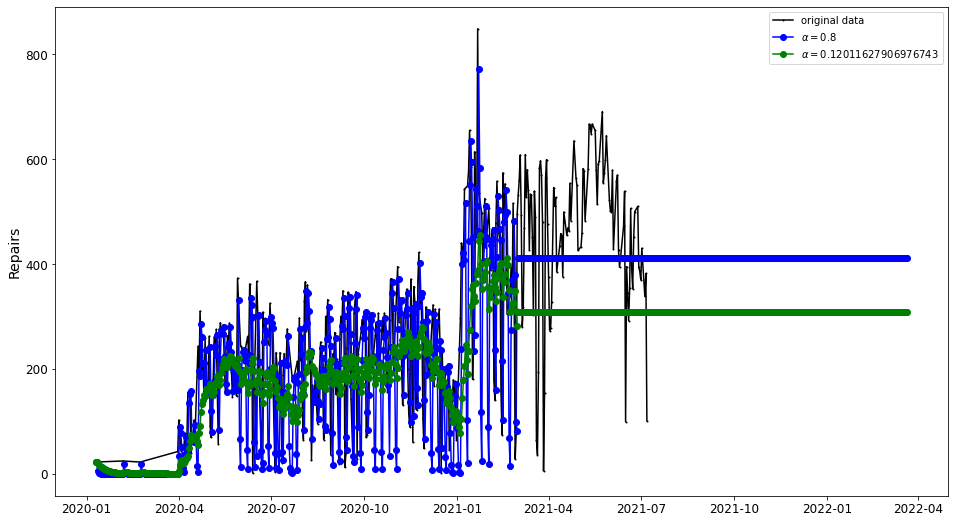

In [14]:
stats.simple_exponential_smoothing(
    y, 
    y.asfreq('D').fillna(0)[:'2021-03-01'],#y_to_train, 
    y.asfreq('D').fillna(0)['2021-03-02':],#y_to_val, 
    0.8, 
    predict_date
    )

### Holt’s Linear Trend Method

- Suitable for time series data with a trend component but without a seasonal component 
- In addition to the level smoothing parameter α introduced with the SES method, the Holt method adds the trend smoothing parameter β*. Like with parameter α, the range of β* is also between 0 and 1.

The Root Mean Squared Error of Holt's Linear trend nan
The Root Mean Squared Error of Holt's Exponential trend nan


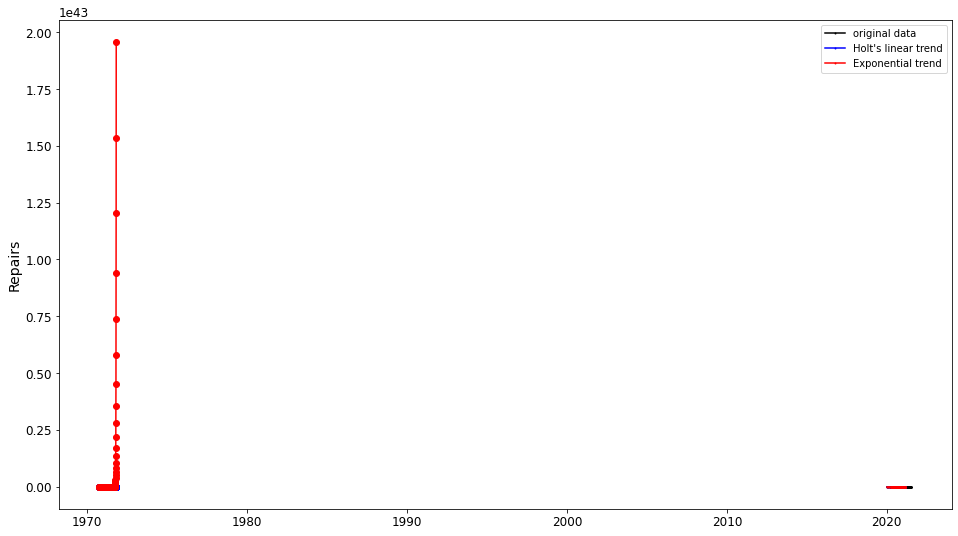

In [15]:
stats.holt(
    y,
    y[:'2021-03-01'],#y_to_train, 
    y['2021-03-02':],#y_to_val,
    0.6,
    0.2,
    predict_date
)

### Holt-Winters’ Seasonal Method

- Suitable for time series data with trend and/or seasonal components
- Includes this seasonality smoothing parameter: γ.

There are two general types of seasonality: Additive and Multiplicative. 

- Additive: xt = Trend + Seasonal + Random 
- Multiplicative: xt = Trend * Seasonal * Random

In [16]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped_trend=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped_trend=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=2 and a Box-Cox transformation 250.4
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=2 and a Box-Cox transformation 282.89


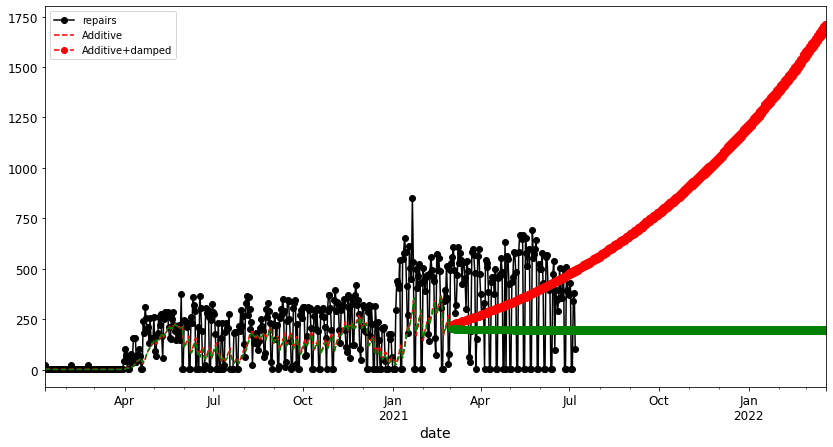

In [17]:
holt_win_sea(
    y.asfreq('D').fillna(1), 
    y_to_train.asfreq('D').fillna(1),
    y_to_val.asfreq('D').fillna(1),
    'additive',
    2, 
    predict_date
)

### SARIMA

### Suitable for time series data with trend and/or seasonal components

Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data

Trend Elements:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

Seasonal Elements:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.


In [18]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [19]:
sarima_grid_search(y,2)

UnboundLocalError: local variable 'param_mini' referenced before assignment

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pandas.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pandas.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [ ]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 1, 2),2,'2021-04-01',y_to_val)

## Making Predictions

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name) 
    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
final_table = forecast(model,2,y)
final_table.head()

In [ ]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=2)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

In [ ]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
#ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
#ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Repairs')
ax.legend()